In [1]:
from data_processing import *
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from model import *

import matplotlib.pyplot as plt
from IPython.display import clear_output, display


import numpy as np
import os

In [2]:
velocity_path = '../data'
normalized_velocities, _ = combine_and_normalize_velocity_files(velocity_path)

In [3]:
print(np.info(normalized_velocities))

class:  ndarray
shape:  (325, 2)
strides:  (16, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x21879672dd0
byteorder:  little
byteswap:  False
type: float64
None


In [4]:
data_transform = transforms.Compose([
    transforms.Resize(224), #mobilenet expects this size input
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize 
])

In [5]:
image_folder_path = '../data'
# Assuming 'normalized_velocities' and 'image_folder_path' are already defined
full_dataset = PathFollowingDataset(image_folder_path, normalized_velocities, transform=data_transform)

print(full_dataset.image_filenames[:5])
# Define the size of the training and validation sets 80/20 train/test split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Randomly split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(full_dataset[1])

['image0.jpg', 'image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg']
{'image': tensor([[[ 0.0275,  0.0353,  0.0431,  ..., -0.8824, -0.8902, -0.8667],
         [ 0.0275,  0.0353,  0.0431,  ..., -0.8824, -0.8902, -0.8667],
         [ 0.0275,  0.0353,  0.0431,  ..., -0.8902, -0.8902, -0.8667],
         ...,
         [-0.5137, -0.5137, -0.5137,  ..., -0.7882, -0.7804, -0.7804],
         [-0.4980, -0.4980, -0.5059,  ..., -0.7961, -0.7882, -0.7882],
         [-0.5608, -0.5686, -0.5686,  ..., -0.8039, -0.7961, -0.7961]]]), 'velocity': tensor([0.3222, 0.3479])}


c:\Users\kxfor\OneDrive\Documents\Projects\Autonomous-Driving-Project\path_tracking\data_processing.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'image': torch.tensor(image, dtype=torch.float), 'velocity': torch.tensor(velocity, dtype=torch.float)}


In [6]:

# Define the DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
model = getMobileNet(isPretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

In [8]:
def train_and_validate_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=50, patience = 5, min_loss_change=0.01):
    model.train()  # Set the model to training mode initially

    train_losses = []
    val_losses = []
    epochs_no_improve = 0
    last_loss = float('inf')

    # Create a figure for plotting
    plt.figure(figsize=(10, 5))
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_losses = []

        # Training Phase
        for i, data in enumerate(train_dataloader, 0):
            inputs = data['image'].to(device)
            targets = data['velocity'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_losses.append(loss.item())

            if i % 10 == 9:    # Print every 10 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        # if epoch != 0:
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()  # Set the model to evaluation mode for validation
        val_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                inputs = data['image'].to(device)
                targets = data['velocity'].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # Checkpointing
        if epoch == 24 or epoch == 35:
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')
            print(f'Model saved at epoch {epoch+1}')
        
        if avg_train_loss < 0.2 and avg_val_loss < 0.2:
            torch.save(model.state_dict(), f'model_low_loss_epoch_{epoch+1}.pth')
            print(f'Model saved with low loss at epoch {epoch+1}')

        # check convergence
        if abs(avg_train_loss - last_loss) < min_loss_change:
            epochs_no_improve+=1
        else:
            epochs_no_improve=0

        if epochs_no_improve >= patience:
            torch.save(model.state_dict(), f'model_coverged_epoch_{epoch+1}.pth')
            print(f'Model has converged and saved at epoch {epoch+1}')
            break

        last_loss = avg_train_loss

        # Plotting
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.yscale('log')  # Set the y-axis to logarithmic scale
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss')
        plt.title('Training and Validation Loss on Log Scale')
        plt.legend()
        
        clear_output(wait=True)
        # display(plt.gcf())
        
        plt.pause(0.001)
        print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}')
        print(" ")
        print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}')


        model.train()  # Reset to training mode for the next epoch

    plt.show()
    print('Finished Training and Validation')


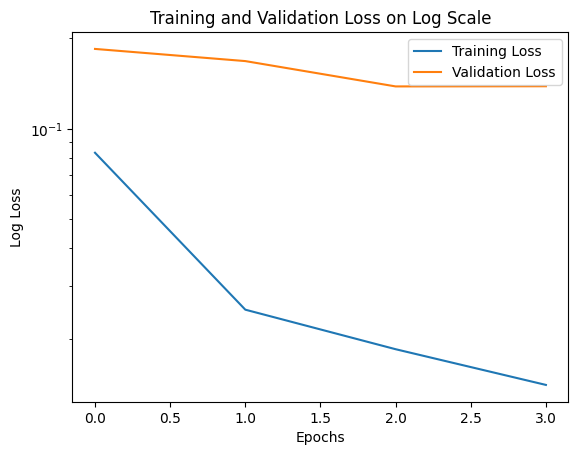

Epoch 4, Validation Loss: 0.1382
 
Epoch 4, Training Loss: 0.0140


KeyboardInterrupt: 

In [9]:
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=75)
